In [7]:
# -*- coding: utf-8 -*-

'''

这里用erp，因为单个trial的噪音很大，做不出结果。

但是为了保证公平（有的条件比较少），进行抽样，所以数据读的依然是epoch的数据。



'''

__author__ = ' liangyaowen '

In [8]:
import numpy as np
import os.path as op
from pandas import read_csv
import mne
from mne.io import read_raw_fif
from mne.datasets import visual_92_categories
from neurora.nps_cal import nps
from neurora.rdm_cal import eegRDM
from neurora.rdm_corr import rdm_correlation_spearman
from neurora.corr_cal_by_rdm import rdms_corr
from neurora.rsa_plot import plot_rdm, plot_corrs_by_time, plot_nps_hotmap, plot_corrs_hotmap

In [9]:
"""
数据应该是从epochs里读，每个epoch的标签不一样才对
简化：
先读一个被试的数据看看
每个epoch对应一个condition（关键的是数量不对等问题-不同条件epoch数量不等，要不要随机抽取？假设每个抽取12个）

"""
T1_sub_ids = [
            'prex047'  ]

T2M_sub_ids = [
            'prex047M' ]

T2S_sub_ids = [
            'prex047S' ]
data_path = 'E:\Python LYW\RSA\spaced_learning\pre10\\analysis\data\\6epoch_clean\\'

list_epochs_T1S = list()
list_epochs_T2S = list()
list_epochs_T2M = list()

for sub_id in T1_sub_ids:
    fname = data_path + sub_id + '-epo.fif'
    epochs = mne.read_epochs(fname)

    list_epochs_T1S.append(epochs)

for sub_id in T2S_sub_ids:
    fname = data_path + sub_id + '-epo.fif'
    epochs = mne.read_epochs(fname)
    list_epochs_T2S.append(epochs)

for sub_id in T2M_sub_ids:
    fname = data_path + sub_id + '-epo.fif'
    epochs = mne.read_epochs(fname)
    list_epochs_T2M.append(epochs)

list_rdms = list()

Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\6epoch_clean\prex047-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\6epoch_clean\prex047S-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\6epoch_clean\prex047M-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
44 matching events found
No baseline correction applied
0 pr

In [10]:
#制作出完整的epochs

# 先找出最少的那个，有时候不一定是 一次！
minnum_epochs = min(len(list_epochs_T1S[0].events),
                     len(list_epochs_T2M[0].events),
                     len(list_epochs_T2S[0].events))

import random

for i in range(20):
    epochs_type1 = list_epochs_T1S[0]
    #随机抽样epochs
    epochs_type2 = list_epochs_T2M[0][0]
    for i_M in random.sample(range(1,len(list_epochs_T2M[0].events)),minnum_epochs-1):
        epochs_type2 = mne.concatenate_epochs([epochs_type2,list_epochs_T2M[0][i_M]])

    epochs_type3 = list_epochs_T2S[0][0]
    for i_S in random.sample(range(1,len(list_epochs_T2S[0].events)),minnum_epochs-1):
        epochs_type3 = mne.concatenate_epochs([epochs_type3,list_epochs_T2S[0][i_S]])

    list_epochs_3types = [epochs_type1,epochs_type2,epochs_type3]


    # the shape of MEG data: megdata is [3, 92, 306, 1101]
    # n_subs = 3, n_conditions = 92, n_channels = 306, n_timepoints = 1101 (-100ms to 1000ms)
    subindex = 0
    #注意第一个维度是subs
    eegdata = np.zeros([len(T1_sub_ids),3, 63, 501], dtype=np.float32)
    #第一个维度是condition
    subdata = np.zeros([3, 63, 501], dtype=np.float32)
    for i in range(3):
        data = list_epochs_3types[i].average().data
        subdata[i] = data
    eegdata[subindex] = subdata

    explevels = 3
    num_subs = len(T1_sub_ids)
    # shape of megdata: [n_subs, n_cons, n_chls, n_ts] -> [n_cons, n_subs, n_chls, n_ts]
    eegdata = np.transpose(eegdata, (1, 0, 2, 3))

    # shape of megdata: [n_cons, n_subs, n_chls, n_ts] -> [n_cons, n_subs, n_trials, n_chls, n_ts]
    # here data is averaged, so set n_trials = 1
    eegdata = np.reshape(eegdata, [explevels, num_subs , 1, 63, 501])


    ' a function for plotting the RDM '

    import matplotlib.pyplot as plt

    def plot_rdm(rdm, percentile=False, rescale=False, lim=[0, 1], conditions=None, con_fontsize=12, cmap=None):

        """
        Plot the RDM

        Parameters
        ----------
        rdm : array or list [n_cons, n_cons]
            A representational dissimilarity matrix.
        percentile : bool True or False. Default is False.
            Rescale the values in RDM or not by displaying the percentile.
        rescale : bool True or False. Default is False.
            Rescale the values in RDM or not.
            Here, the maximum-minimum method is used to rescale the values except for the
            values on the diagnal.
        lim : array or list [min, max]. Default is [0, 1].
            The corrs view lims.
        conditions : string-array or string-list. Default is None.
            The labels of the conditions for plotting.
            conditions should contain n_cons strings, If conditions=None, the labels of conditions will be invisible.
        con_fontsize : int or float. Default is 12.
            The fontsize of the labels of the conditions for plotting.
        cmap : matplotlib colormap. Default is None.
            The colormap for RDM.
            If cmap=None, the ccolormap will be 'jet'.
        """

        if len(np.shape(rdm)) != 2 or np.shape(rdm)[0] != np.shape(rdm)[1]:

            return "Invalid input!"

        # get the number of conditions
        cons = rdm.shape[0]

        # if cons=2, the RDM cannot be plotted.
        if cons == 2:
            print("The shape of RDM cannot be 2*2. Here NeuroRA cannot plot this RDM.")

            return None

        # determine if it's a square
        a, b = np.shape(rdm)
        if a != b:
            return None

        if percentile == True:

            v = np.zeros([cons * cons, 2], dtype=np.float)
            for i in range(cons):
                for j in range(cons):
                    v[i * cons + j, 0] = rdm[i, j]

            index = np.argsort(v[:, 0])
            m = 0
            for i in range(cons * cons):
                if i > 0:
                    if v[index[i], 0] > v[index[i - 1], 0]:
                        m = m + 1
                    v[index[i], 1] = m

            v[:, 0] = v[:, 1] * 100 / m

            for i in range(cons):
                for j in range(cons):
                    rdm[i, j] = v[i * cons + j, 0]

            if cmap == None:
                plt.imshow(rdm, extent=(0, 1, 0, 1), cmap=plt.cm.jet, clim=(0, 100))
            else:
                plt.imshow(rdm, extent=(0, 1, 0, 1), cmap=cmap, clim=(0, 100))

        # rescale the RDM
        elif rescale == True:

            # flatten the RDM
            vrdm = np.reshape(rdm, [cons * cons])
            # array -> set -> list
            svrdm = set(vrdm)
            lvrdm = list(svrdm)
            lvrdm.sort()

            # get max & min
            maxvalue = lvrdm[-1]
            minvalue = lvrdm[1]

            # rescale
            if maxvalue != minvalue:

                for i in range(cons):
                    for j in range(cons):

                        # not on the diagnal
                        if i != j:
                            rdm[i, j] = float((rdm[i, j] - minvalue) / (maxvalue - minvalue))

            # plot the RDM
            min = lim[0]
            max = lim[1]
            if cmap == None:
                plt.imshow(rdm, extent=(0, 1, 0, 1), cmap=plt.cm.jet, clim=(min, max))
            else:
                plt.imshow(rdm, extent=(0, 1, 0, 1), cmap=cmap, clim=(min, max))

        else:

            # plot the RDM
            min = lim[0]
            max = lim[1]
            if cmap == None:
                plt.imshow(rdm, extent=(0, 1, 0, 1), cmap=plt.cm.jet, clim=(min, max))
            else:
                plt.imshow(rdm, extent=(0, 1, 0, 1), cmap=cmap, clim=(min, max))

        # plt.axis("off")
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=16)
        font = {'size': 18}

        if percentile == True:
            cb.set_label("Dissimilarity (percentile)", fontdict=font)
        elif rescale == True:
            cb.set_label("Dissimilarity (Rescaling)", fontdict=font)
        else:
            cb.set_label("Dissimilarity", fontdict=font)

        if conditions != None:
            print("1")
            step = float(1 / cons)
            x = np.arange(0.5 * step, 1 + 0.5 * step, step)
            y = np.arange(1 - 0.5 * step, -0.5 * step, -step)
            plt.xticks(x, conditions, fontsize=con_fontsize, rotation=30, ha="right")
            plt.yticks(y, conditions, fontsize=con_fontsize)
        else:
            plt.axis("off")

        plt.show()

        return 0


    #Section 5: Calculating RDMs and Plotting
    # Calculate the RDMs by a 10ms time-window
    # (raw sampling requency is 1000Hz, so here time_win=10ms/(1s/1000Hz)/1000=10)
    rdms = eegRDM(eegdata, time_opt=1, time_win=100, time_step=10)
    list_rdms.append(rdms)

Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (m

In [11]:
#对list平均？
# 对rdm进行平均

rdms = sum(list_rdms)/len(list_rdms)

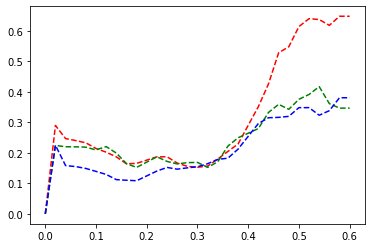

In [12]:
# 考虑直接 画出 三条线；一次 vs 集中、集中  vs 分散、 一次 vs 分散
# 这应该算是对向量作图？ 先提取出来。
#
y1 = rdms[10:,0,1]#一次 VS 集中
y2 = rdms[10:,1,2]#集中 vs 分散
y3 = rdms[10:,0,2]#一次 vs 分散
y1[0] = 0
y1[10]= (y1[9]+y1[11])/2
y1[20]=(y1[19]+y1[21])/2
y1[30]=y1[29]

y2[0] = 0
y2[10]= (y2[9]+y2[11])/2
y2[20]=(y2[19]+y2[21])/2
y2[30]=y2[29]

y3[0] = 0
y3[10]= (y3[9]+y3[11])/2
y3[20]=(y3[19]+y3[21])/2
y3[30]=y3[29]
x = np.arange(0,0.62,0.02)
l1=plt.plot(x,y1,'r--',label='type1')
l2=plt.plot(x,y2,'g--',label='type2')
l3=plt.plot(x,y3,'b--',label='type3')

plt.show()
